# Episode 03 c: Game Engine

Checking the board visually is fine for debugging but it does not work well when it comes to test a lot of board solutions.

This episode provides some utilities for the POC to come. The goal is to have reasonably efficient classes but not spend too much time on this step.

**Goals for this episode:**
- Answer recurring questions 
    - What are the width, height, nulber of cellss of the puzzle 
    - Given a board is it completed ? 
    - Does it break the clues ?
    - Are they cells left undefined ? 
    - Am I close to the goal ?


# 1. Elements from episodes 01, 02 and 03

In [1]:
from episode01.samples import clues2x2, clues5x5s, solution2x2, solution5x5s
from episode02.gameengine import GameEngine
from episode03b.puzzle import Puzzle
from episode03b.board import Board, BoardMark
from episode03b.boardplotter import BoardPlotter

import numpy as np

In [2]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

In [3]:
clues5x5s

{'rows': [1, 3, [1, 1], 3, 5], 'cols': [1, 4, [2, 2], 4, 1]}

Requirements listed in Episode 02 still uncovered
- a game engine which provides the game validation for try-and-error validation and solved board - for all kind of puzzles (we have tested 2x2 only)
- some operation thate were identified in episode 01: is the board completed, is the board valid
- a puzzle class with some operations to transform the clues and compute black count and cels count
- try-and-error and learning process will require something in between not done and done in order to improve on residual error or rewards: number of cells completed/undefined, number of errors, number of valid cells


# 2. Experiments

## 2.4. check numbers of cells left empty

Check for undefined cells existence

In [4]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 1, BoardMark.BLACK) 
board2x2.prettyprint()

cols: 2 1
rows:
1
2
[['.' 'x']
 ['.' 'o']]


In [5]:
# filter the cells having an undegined value 
# reshaping in a list of lenght equald to the number of cells 
# avoid having to browse a list of lists
[ c for c in board2x2.states.reshape(4) if c == -1]

[-1, -1]

In [6]:
board2x2.states.shape

(2, 2)

In [7]:
# totézl number of cells
from operator import mul
from functools import reduce
reduce(mul, board2x2.states.shape)

4

TODO explain reduce

In [8]:
from operator import mul
from functools import reduce

def count_empty(a_board):
    length = reduce(mul, a_board.states.shape)
    count = len([ c for c in a_board.states.reshape(length) 
                         if c == -1])
    return count
  
count = count_empty(board2x2)
print(f"count_empty={count}")
assert count == 2

count_empty=2


Check for 5x5

In [9]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}

In [10]:
puzzle5x5s = Puzzle(clues5x5s)
board5x5s = Board(puzzle5x5s)
board5x5s.mark(4, 0, BoardMark.BLACK) 
board5x5s.mark(2, 2, BoardMark.FILLER) 
board5x5s.prettyprint()
count = count_empty(board5x5s)
print(f"count_empty={count}")
assert count == reduce(mul, board5x5s.states.shape) - 2

cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['.' '.' 'x' '.' '.']
 ['.' '.' '.' '.' '.']
 ['o' '.' '.' '.' '.']]
count_empty=23


## 2.5. Check whether board hold the clues

In [11]:
puzzle2x2 = Puzzle(clues2x2)
norm_clues2x2 = puzzle2x2.norm_clues
norm_clues2x2

{'rows': [[1], [2]], 'cols': [[2], [1]]}

In [12]:
board2x2 = Board(puzzle2x2)
board2x2.prettyprint()
board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 0, BoardMark.BLACK) 
board2x2.mark(1, 1, BoardMark.BLACK) 
board2x2.prettyprint()

cols: 2 1
rows:
1
2
[['.' '.']
 ['.' '.']]
cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [13]:
rows = board2x2.states
rows

array([[1, 0],
       [1, 1]])

In [14]:
from itertools import groupby

In [15]:
# group cells by value and select groups where group key is 1 (BLACK)
[ [(k, *g) for k,g in groupby(line) if k==1]
  for line in rows
]
# it outputs tuples where the first element is the key, 
# and the rest are the elements in the 
# there are two list (one for each row)
# row 0 : has 1 black cell (1=BLACK key, 1=the cell)
# row 1 : has 2 black cells (1=BLACK key, 1,1=the cells)

[[(1, 1)], [(1, 1, 1)]]

In [16]:
# transform to a list of block length
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows
]
print(f"blocks={blocks}")
assert blocks == norm_clues2x2['rows'] 

blocks=[[1], [2]]


In [17]:
assert blocks == norm_clues2x2['rows'] 

In [18]:
w = board2x2.states.shape[0]
h = board2x2.states.shape[1]
length = mul(w, h)
cols = [ [board2x2.states.reshape(length)[c+r*w]
         for r in range(0, h)]
         for c in range(0, w)]
cols

[[1, 1], [0, 1]]

In [19]:
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
  for line in cols
]
print(f"blocks={blocks}")
assert blocks == norm_clues2x2['cols'] 

blocks=[[2], [1]]


In [20]:
def get_rows_blocks(a_board):
    rows = a_board.states
    blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows
    ]
    return blocks

def get_cols_blocks(a_board):
    w = a_board.states.shape[0]
    h = a_board.states.shape[1]
    length = mul(w, h)
    cols = [ [a_board.states.reshape(length)[c+r*w]
         for r in range(0, h)]
         for c in range(0, w)]
    blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
      for line in cols
    ]
    return blocks

In [21]:
assert get_rows_blocks(board2x2) == norm_clues2x2['rows'] 

In [22]:
assert get_cols_blocks(board2x2)  == norm_clues2x2['cols'] 

check 5x5s

In [23]:
puzzle5x5s = Puzzle(clues5x5s)
board5x5s = Board(puzzle5x5s)
board5x5s.mark(4, 0, BoardMark.BLACK) 
board5x5s.mark(2, 2, BoardMark.FILLER) 
board5x5s.prettyprint()
count = count_empty(board5x5s)
print(f"count empty={count}")


cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['.' '.' 'x' '.' '.']
 ['.' '.' '.' '.' '.']
 ['o' '.' '.' '.' '.']]
count empty=23


In [24]:
get_rows_blocks(board5x5s)

[[], [], [], [], [1]]

In [25]:
# 1 BLACK on row 4
assert get_rows_blocks(board5x5s) == [[], [], [], [], [1]]

In [26]:
get_cols_blocks(board5x5s)

[[1], [], [], [], []]

In [27]:
# 1 BLACK on col 0
assert get_cols_blocks(board5x5s) == [[1], [], [], [], []]

## 2.6. Get score

Score may be computed
- from the number of errors in try-and-error process
- from the number of differences between proposed solutiion and the known solutiion
- from the number of violations of the clues

In [28]:
# difference between proposed and expected

proposed = [1, 1, 0, 1]
expected = [1, 0, 1, 1]
[(p,e) for (p,e) in zip(proposed, expected)]

[(1, 1), (1, 0), (0, 1), (1, 1)]

In [29]:
[abs(p-e) for (p,e) in zip(proposed, expected)]

[0, 1, 1, 0]

In [30]:
errors = sum([abs(p-e) for (p,e) in zip(proposed, expected)])
errors

2

In [31]:
# score
(len(expected) - errors) / len(expected)

0.5

In [32]:
# take left empty into account
proposed = [1, -1, 0, 1]
[abs(p-e) for (p,e) in zip(proposed, expected) if p>=0]

[0, 1, 0]

In [33]:
errors = sum([abs(p-e) for (p,e) in zip(proposed, expected) if p>=0])
errors

1

In [34]:
empty = sum([abs(p) for p in proposed if p<0])
empty

1

In [35]:
# score
(len(expected) - errors - empty) / len(expected)

0.5

In [36]:
# TODO score for board update

## count errors 

In [37]:
list(zip(blocks, puzzle2x2.norm_clues["rows"]))

[([2], [1]), ([1], [2])]

In [38]:
[abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle2x2.norm_clues["rows"])]

[1, 1]

In [39]:
sum([abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle2x2.norm_clues["rows"])])

2

In [40]:
states = np.array([[1,1], [1,1]])
rows = states
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows]
blocks

[[2], [2]]

In [41]:
sum([abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle2x2.norm_clues["rows"])])

1

In [42]:
puzzle5x5s = Puzzle(clues5x5s)
puzzle5x5s.norm_clues["rows"]

[[1], [3], [1, 1], [3], [5]]

In [43]:
rows = solution5x5s
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows]
blocks

[[1], [3], [1, 1], [3], [5]]

In [44]:
sum([abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle5x5s.norm_clues["rows"])])

0

In [45]:
blocks = [[1], [3], [0, 1], [3], [5]]
sum([abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle5x5s.norm_clues["rows"])])

1

In [46]:
blocks = [[1], [3], [0, -1], [3], [5]]
sum([abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle5x5s.norm_clues["rows"])])

3

## nb blacks

In [47]:
states = np.array([[-1,0], [1,1]])
rows = states
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows]
blocks

[[], [2]]

In [48]:
sum([abs(sum(b)-sum(c)) for (b,c) in zip(blocks, puzzle2x2.norm_clues["rows"])])

1

## autofill board

In [49]:
states = np.array([[1,-1], [1,1]])
states = np.where(states == -1, 0, states)
states

array([[1, 0],
       [1, 1]])

In [50]:
## nb diff with solution


In [51]:
flat_solution = solution2x2.reshape(4).tolist()
flat_solution

[1, 0, 1, 1]

In [52]:
proposed_solution = [1, 1, 0, 1]

In [53]:
[abs(p-s) for p,s in zip(proposed_solution, flat_solution)]

[0, 1, 1, 0]

In [54]:
proposed_solution = [1, -1, 0, 1]

In [55]:
[abs(p-s) for p,s in zip(proposed_solution, flat_solution) if p!=-1] 

[0, 1, 0]

In [56]:
sum([abs(p-s) for p,s in zip(proposed_solution, flat_solution) if p!=-1] )

1

## play multiple

In [57]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)

In [58]:
def play_multiple(row, col, mark, axis, count):
    if axis == 0: # row
        for i in range(col, min(2,col+count)):
            board2x2.mark(row, i, mark) 
    if axis == 1: # row
        for i in range(row, min(2,row+count)):
            board2x2.mark(i, col, mark) 

In [59]:
play_multiple(0, 0, BoardMark.BLACK, 0, 2) 

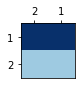

In [60]:
plotter2x2 = BoardPlotter(puzzle2x2)
plotter2x2.show(board2x2)

In [61]:
play_multiple(0, 0, BoardMark.BLACK, 1, 2) 

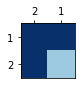

In [62]:
plotter2x2.show(board2x2)

In [63]:
# out of bound
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
play_multiple(1, 1, BoardMark.BLACK, 1, 2) 

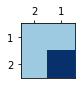

In [64]:
plotter2x2.show(board2x2)

# 3. updated classes 

In [65]:
%reset -f

TODO

Some solver will do operations on clues without having a board. For instance evaluate the total number of blacks cells in order to randomly place an equal nulber of blacks.

The game rules must be a separate class.

In [66]:
from episode01.samples import clues2x2, clues5x5s, solution2x2, solution5x5s
from episode03b.board import BoardMark

## 3.1. Game Engine class

TODO explain why puzzle out of game engine

In [67]:
%reset -f

In [68]:
from episode01.samples import clues2x2, clues5x5s, solution2x2, solution5x5s
from episode03b.board import Board, BoardMark
from episode03b.boardplotter import BoardPlotter
from episode03b.puzzle import Puzzle
from episode03c.gameengine import BoardGameEngine, NonoGameEngine, SolvedNonoGameEngine

Changes to the class GameEngine

TODO

use puzlle

check whether rules are borcken

game progress utilities

classes implementatation [gameengine.py](https://raw.githubusercontent.com/cfalguiere/python_experiments/master/nono/episode03c/gameengine.py)

### class BoardGameEngine

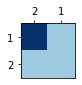

In [69]:
puzzle2x2 = Puzzle(clues2x2)
game2x2 = BoardGameEngine(puzzle2x2)
board2x2 = game2x2.board
board2x2.mark(0, 0, BoardMark.BLACK) 
game2x2.show()

### class NonoGameEngine

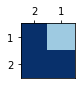

In [70]:
# no errors 
puzzle2x2 = Puzzle(clues2x2)
game2x2 = NonoGameEngine(puzzle2x2)

game2x2.play(0, 0, BoardMark.BLACK) 
assert game2x2.count_empty() == 3
assert not game2x2.is_solved()

game2x2.play(1, 0, BoardMark.BLACK) 
game2x2.play(1, 1, BoardMark.BLACK) 

assert game2x2.count_empty() == 1
assert game2x2.count_errors() == 0
assert game2x2.is_solved()

game2x2.show()

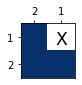

In [71]:
# submit no errors
puzzle2x2 = Puzzle(clues2x2)
game2x2 = NonoGameEngine(puzzle2x2)

n_errors = game2x2.submit([1,0,1,1])
assert n_errors == 0
assert game2x2.count_empty() == 0
assert game2x2.count_errors() == 0
assert game2x2.is_solved()

game2x2.show()

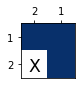

In [72]:
# submit with errors
puzzle2x2 = Puzzle(clues2x2)
game2x2 = NonoGameEngine(puzzle2x2)

n_errors = game2x2.submit([1,1,0,1])
assert n_errors == 2
assert game2x2.count_empty() == 0
assert game2x2.count_errors() == 2
assert not game2x2.is_solved()

game2x2.show()

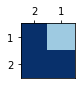

In [73]:
# multiple
puzzle2x2 = Puzzle(clues2x2)
game2x2 = NonoGameEngine(puzzle2x2)

game2x2.play_multiple(0, 0, BoardMark.BLACK, 1, 2) 
game2x2.play_multiple(1, 0, BoardMark.BLACK, 0, 2) 

assert game2x2.count_empty() == 1
assert game2x2.count_errors() == 0

game2x2.show()

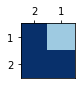

In [74]:
# multiple out of bound
puzzle2x2 = Puzzle(clues2x2)
game2x2 = NonoGameEngine(puzzle2x2)

game2x2.play_multiple(0, 0, BoardMark.BLACK, 1, 2) 
game2x2.play_multiple(1, 1, BoardMark.BLACK, 0, 2) 

assert game2x2.count_empty() == 1
assert game2x2.count_errors() == 0

game2x2.show()

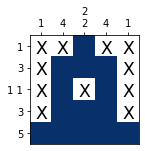

In [75]:
# submit 5x5s
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.is_consistent()

game5x5s = NonoGameEngine(puzzle5x5s)

game5x5s.submit(solution5x5s.reshape(puzzle5x5s.cells_count).tolist())
assert game5x5s.is_solved()

game5x5s.show()

### class SolvedNonoGameEngine

Test 2x2

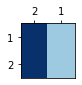

In [76]:
# one at a time 
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2)
okay = game2x2.play(0, 0, BoardMark.FILLER) # error -> fixed but colunted error
assert not okay
okay = game2x2.play(1, 0, BoardMark.BLACK) # correct
assert okay
assert game2x2.errors == 1
game2x2.show()

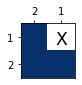

In [77]:
# submit no errors
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2)

n_errors = game2x2.submit([1,0,1,1])
assert n_errors == 0
assert game2x2.count_empty() == 0
assert game2x2.count_errors() == 0
assert game2x2.is_solved()

game2x2.show()

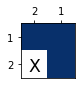

In [78]:
# submit with errors
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2)

n_errors = game2x2.submit([1,1,0,1])
assert n_errors == 2
assert game2x2.count_empty() == 0
assert game2x2.count_errors() == 2
assert not game2x2.is_solved()

game2x2.show()

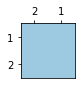

In [79]:
# play no apply
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2)

okay = game2x2.play(0, 0, BoardMark.FILLER, apply=False) 
assert not okay
assert game2x2.count_errors() == 1 # wrong play
assert game2x2.count_empty() == 4
assert not game2x2.is_solved()

game2x2.show()

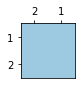

In [80]:
# submit no apply
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2)

n_errors = game2x2.submit([1,1,0,1], apply=False)
assert n_errors == 2
assert game2x2.count_errors() == 2 
assert game2x2.count_empty() == 4
assert not game2x2.is_solved()

game2x2.show()

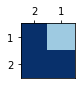

In [81]:
# multiple
puzzle2x2 = Puzzle(clues2x2)
game2x2 = SolvedNonoGameEngine(puzzle2x2, solution2x2)

game2x2.play_multiple(0, 0, BoardMark.BLACK, 1, 2) 
game2x2.play_multiple(1, 0, BoardMark.BLACK, 0, 2) 

assert game2x2.count_empty() == 1
assert game2x2.count_errors() == 0

game2x2.show()

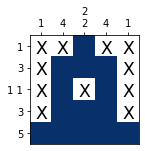

In [82]:
# submit 5x5s
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.is_consistent()

game5x5s = SolvedNonoGameEngine(puzzle5x5s, solution5x5s)

game5x5s.submit(solution5x5s.reshape(puzzle5x5s.cells_count).tolist())
assert game5x5s.is_solved()

game5x5s.show()

# 5. Wrap up

We have learned
- groupby
- Polumorphism

The class and solutions are saved in episode03c.py.


5.1. Quick test of saved classes

In [83]:
# reset all variables from tests
%reset -f

In [84]:
from episode01.samples import clues2x2, clues5x5s, solution2x2, solution5x5s
from episode03b.board import Board, BoardMark
from episode03b.boardplotter import BoardPlotter
from episode03b.puzzle import Puzzle
from episode03c.gameengine import NonoGameEngine, SolvedNonoGameEngine

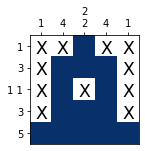

In [85]:
# submit 5x5s
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.is_consistent()

game5x5s = NonoGameEngine(puzzle5x5s)

game5x5s.submit(solution5x5s.reshape(puzzle5x5s.cells_count).tolist())
assert game5x5s.is_solved()

game5x5s.show()

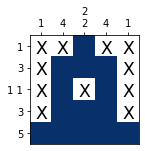

In [86]:
# submit 5x5s
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.is_consistent()

game5x5s = SolvedNonoGameEngine(puzzle5x5s, solution5x5s)

game5x5s.submit(solution5x5s.reshape(puzzle5x5s.cells_count).tolist())
assert game5x5s.is_solved()

game5x5s.show()

In [87]:
print('okay')

okay
